In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns


# ==========================
# 0. Cấu hình chung
# ==========================
RANDOM_STATE = 42
DATA_PATH = r"D:\elliptic\blte\Labeled-Transactions-based-Dataset-of-Ethereum-Network-master\FinalDataset.xlsx"
# (hoặc .xlsx nếu bạn dùng bản excel -> dùng read_excel)

In [2]:
# ==========================
# 1. Load final_dataset
# ==========================
df = pd.read_excel(DATA_PATH)

print("Số dòng ban đầu:", len(df))
print("Các cột:", df.columns.tolist())

Số dòng ban đầu: 71250
Các cột: ['hash', 'nonce', 'transaction_index', 'from_address', 'to_address', 'value', 'gas', 'gas_price', 'input', 'receipt_cumulative_gas_used', 'receipt_gas_used', 'block_timestamp', 'block_number', 'block_hash', 'from_scam', 'to_scam', 'from_category', 'to_category']


In [3]:
# ==========================
# 2. Tạo nhãn transaction-level
# ==========================
# Điền thiếu cho from_scam/to_scam (nếu có NaN)
for col in ["from_scam", "to_scam"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# 1 = abnormal nếu from hoặc to là scam
df["label"] = (
    (df.get("from_scam", 0) == 1) |
    (df.get("to_scam", 0) == 1)
).astype(int)

LABEL_COL = "label"

print("Phân bố nhãn (0=normal, 1=abnormal):")
print(df[LABEL_COL].value_counts())

y = df[LABEL_COL].values

Phân bố nhãn (0=normal, 1=abnormal):
label
0    57000
1    14250
Name: count, dtype: int64


In [4]:
# ==========================
# 3. Chọn feature (tránh rò rỉ label)
# ==========================

# Các cột KHÔNG dùng làm feature:
drop_id_cols = [
    'block_number',
    'block_timestamp',
    "hash",          # tx hash
    'transaction_index',
    "from_address",  # địa chỉ
    "to_address",
    "block_hash",
    "input"          # raw input data, text dài
]

drop_label_cols = [
    "from_scam", "to_scam",
    "from_category", "to_category",
    LABEL_COL
]

cols_to_drop = [c for c in drop_id_cols + drop_label_cols if c in df.columns]

# Ban đầu, lấy tất cả cột trừ mấy cột drop
feature_candidates = [c for c in df.columns if c not in cols_to_drop]
X_df = df[feature_candidates].copy()

# ---- XỬ LÝ block_timestamp TRƯỚC KHI LỌC NUMERIC ----
if "block_timestamp" in X_df.columns:
    # Trường hợp block_timestamp là chuỗi datetime -> convert sang datetime rồi sang int
    if not np.issubdtype(X_df["block_timestamp"].dtype, np.number):
        # cố gắng parse datetime; errors='coerce' nếu có ô lỗi sẽ thành NaT
        X_df["block_timestamp"] = pd.to_datetime(X_df["block_timestamp"], errors="coerce")
        # chuyển về "số giây từ epoch" (hoặc .view('int64') nếu bạn muốn ns)
        X_df["block_timestamp"] = X_df["block_timestamp"].astype("int64") // 10**9
    # nếu đã là số (unix time) thì thôi, giữ nguyên

# Giữ lại cột numeric để dùng cho ML
non_numeric = X_df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print("Bỏ cột không phải số:", non_numeric)
    X_df = X_df.drop(columns=non_numeric)

feature_cols = X_df.columns.tolist()
print("Feature dùng để train:", feature_cols)

X = X_df.values


Feature dùng để train: ['nonce', 'value', 'gas', 'gas_price', 'receipt_cumulative_gas_used', 'receipt_gas_used']


In [5]:
# ==========================
# 3b. Kiểm tra tương quan feature với label
# ==========================

# Ở đây ta dùng chính X_df (sau khi đã drop ID/label, xử lý timestamp, bỏ non-numeric)
# và cột nhãn LABEL_COL trong df.

# Gộp X_df (feature) với cột label thành một DataFrame chung
corr_df = pd.concat(
    [
        X_df.reset_index(drop=True),
        df[LABEL_COL].reset_index(drop=True)
    ],
    axis=1
)

# Tính ma trận tương quan Pearson
corr_matrix = corr_df.corr()

# Lấy vector tương quan của từng feature với label
corr_with_label = corr_matrix[LABEL_COL].drop(labels=[LABEL_COL])  # bỏ chính label

# Giá trị tuyệt đối để xem mức độ mạnh/yếu
corr_with_label_abs = corr_with_label.abs().sort_values(ascending=False)

print("\nTop 30 feature có |corr| lớn nhất với label:")
print(corr_with_label_abs.head(30))

# Nếu muốn xem cả dấu và |corr| dưới dạng bảng:
corr_table = pd.DataFrame({
    "corr": corr_with_label,
    "abs_corr": corr_with_label_abs
}).sort_values("abs_corr", ascending=False)

corr_table.head(30)



Top 30 feature có |corr| lớn nhất với label:
nonce                          0.120640
receipt_cumulative_gas_used    0.110460
receipt_gas_used               0.105110
gas_price                      0.048455
gas                            0.022670
value                          0.015716
Name: label, dtype: float64


,corr,abs_corr
nonce,-0.120640,0.120640
receipt_cumulative_gas_used,0.110460,0.110460
receipt_gas_used,0.105110,0.105110
gas_price,-0.048455,0.048455
gas,0.022670,0.022670
value,-0.015716,0.015716


In [6]:
# ==========================
# 4. Chia train / val / test (stratified)
# ==========================
TEST_SIZE = 0.15
VAL_SIZE  = 0.15

# B1: tách TEST
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# B2: tách TRAIN & VAL từ phần còn lại
val_ratio_in_temp = VAL_SIZE / (1.0 - TEST_SIZE)  # ~0.1765

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio_in_temp,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

def show_stats(name, yy):
    counts = np.bincount(yy)
    n0 = counts[0] if len(counts) > 0 else 0
    n1 = counts[1] if len(counts) > 1 else 0
    ratio = n1 / (n0 + n1) if (n0 + n1) > 0 else 0
    print(f"{name:5s}: 0 = {n0:6d}, 1 = {n1:6d}, scam_ratio = {ratio:.6f}")

print("\n=== Phân bố nhãn sau khi chia ===")
show_stats("ALL",  y)
show_stats("Train", y_train)
show_stats("Val",   y_val)
show_stats("Test",  y_test)



=== Phân bố nhãn sau khi chia ===
ALL  : 0 =  57000, 1 =  14250, scam_ratio = 0.200000
Train: 0 =  39900, 1 =   9974, scam_ratio = 0.199984
Val  : 0 =   8550, 1 =   2138, scam_ratio = 0.200037
Test : 0 =   8550, 1 =   2138, scam_ratio = 0.200037


In [7]:
print("Feature dùng để train:", feature_cols)
print("Các cột nghi ngờ (scam/category/label):")
print([c for c in feature_cols
       if any(k in c.lower() for k in ["scam", "category", "label"])])

Feature dùng để train: ['nonce', 'value', 'gas', 'gas_price', 'receipt_cumulative_gas_used', 'receipt_gas_used']
Các cột nghi ngờ (scam/category/label):
[]


In [8]:
# ==========================
# 5. Chuẩn hóa feature
# ==========================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [9]:
print("Train size:", X_train_scaled.shape, "Val size:", X_val_scaled.shape, "Test size:", X_test_scaled.shape)

# sanity check: không lẫn y
print("Số nhãn train:", np.bincount(y_train))
print("Số nhãn val  :", np.bincount(y_val))
print("Số nhãn test :", np.bincount(y_test))


Train size: (49874, 6) Val size: (10688, 6) Test size: (10688, 6)
Số nhãn train: [39900  9974]
Số nhãn val  : [8550 2138]
Số nhãn test : [8550 2138]


In [10]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from scipy.stats import randint, uniform

RANDOM_STATE = 42

def sample_param(dist, rng):
    """Lấy 1 giá trị từ distribution hoặc list."""
    if hasattr(dist, "rvs"):
        return dist.rvs(random_state=rng)
    # nếu là list/tuple
    dist = list(dist)
    return dist[rng.randint(0, len(dist))]

def random_search_single_model(name, base_estimator, param_dist,
                               X_train, y_train, X_val, y_val,
                               n_iter=30):
    print(f"\n===== Random search cho {name} (không k-fold, dùng VAL) =====")
    rng = np.random.RandomState(RANDOM_STATE)
    best_f1 = -1.0
    best_params = None

    for i in range(n_iter):
        # sample 1 bộ siêu tham số
        params = {k: sample_param(v, rng) for k, v in param_dist.items()}

        model = clone(base_estimator)
        model.set_params(**params)
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)

        print(f"Iter {i+1:02d}/{n_iter}: F1(val) = {f1:.4f}, params = {params}")

        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    print(f"\n>>> {name} – best F1(val) = {best_f1:.4f}")
    print("Best params:", best_params)

    # Train lại trên TRAIN+VAL với best_params trước khi test
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])

    best_model = clone(base_estimator)
    best_model.set_params(**best_params)
    best_model.fit(X_train_full, y_train_full)

    return best_model


In [11]:
# Tính scale_pos_weight nếu muốn dùng cho XGB/LGBM
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
print("scale_pos_weight (train):", scale_pos_weight)

scale_pos_weight (train): 4.000401042711049


7. AutoML cho RF / XGB / LGBM

In [12]:

# 1) RandomForest
rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}

best_rf = random_search_single_model(
    "RandomForest",
    rf_base,
    rf_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30
)


===== Random search cho RandomForest (không k-fold, dùng VAL) =====
Iter 01/30: F1(val) = 0.8398, params = {'n_estimators': 302, 'max_depth': 22, 'min_samples_split': 30, 'min_samples_leaf': 15, 'max_features': None, 'class_weight': 'balanced'}
Iter 02/30: F1(val) = 0.8332, params = {'n_estimators': 388, 'max_depth': 23, 'min_samples_split': 40, 'min_samples_leaf': 19, 'max_features': None, 'class_weight': None}
Iter 03/30: F1(val) = 0.8466, params = {'n_estimators': 287, 'max_depth': 23, 'min_samples_split': 37, 'min_samples_leaf': 8, 'max_features': None, 'class_weight': 'balanced'}
Iter 04/30: F1(val) = 0.6924, params = {'n_estimators': 508, 'max_depth': 4, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}
Iter 05/30: F1(val) = 0.8318, params = {'n_estimators': 585, 'max_depth': 23, 'min_samples_split': 34, 'min_samples_leaf': 12, 'max_features': 'log2', 'class_weight': 'balanced'}
Iter 06/30: F1(val) = 0.8208, params = {'n_estimat

In [13]:
# 2) XGBoost
xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    tree_method="hist",      # hoặc "gpu_hist" nếu bạn chạy GPU
    eval_metric="logloss",
    use_label_encoder=False
)
xgb_param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.29),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 10),
    "gamma": uniform(0.0, 5.0),
    "scale_pos_weight": [scale_pos_weight]
}

best_xgb = random_search_single_model(
    "XGBoost",
    xgb_base,
    xgb_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30
)


===== Random search cho XGBoost (không k-fold, dùng VAL) =====


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 01/30: F1(val) = 0.8495, params = {'n_estimators': 302, 'max_depth': 6, 'learning_rate': np.float64(0.28570714885887566), 'subsample': np.float64(0.892797576724562), 'colsample_bytree': np.float64(0.8394633936788146), 'min_child_weight': 7, 'gamma': np.float64(2.229163764267956), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 02/30: F1(val) = 0.8546, params = {'n_estimators': 414, 'max_depth': 10, 'learning_rate': np.float64(0.10677549723031632), 'subsample': np.float64(0.6571467271687763), 'colsample_bytree': np.float64(0.8603553891795411), 'min_child_weight': 5, 'gamma': np.float64(4.8495492608099715), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 03/30: F1(val) = 0.8299, params = {'n_estimators': 691, 'max_depth': 8, 'learning_rate': np.float64(0.010225842093894155), 'subsample': np.float64(0.996884623716487), 'colsample_bytree': np.float64(0.8469926038510867), 'min_child_weight': 6, 'gamma': np.float64(0.03533152609858703), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 04/30: F1(val) = 0.8378, params = {'n_estimators': 760, 'max_depth': 5, 'learning_rate': np.float64(0.12091397746747719), 'subsample': np.float64(0.9932923543227152), 'colsample_bytree': np.float64(0.786705157299192), 'min_child_weight': 5, 'gamma': np.float64(3.0377242595071916), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 05/30: F1(val) = 0.8485, params = {'n_estimators': 220, 'max_depth': 11, 'learning_rate': np.float64(0.02886496196573106), 'subsample': np.float64(0.9795542149013333), 'colsample_bytree': np.float64(0.9862528132298237), 'min_child_weight': 2, 'gamma': np.float64(1.9270825126995805), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 06/30: F1(val) = 0.8584, params = {'n_estimators': 545, 'max_depth': 7, 'learning_rate': np.float64(0.0769592094304232), 'subsample': np.float64(0.6964101864104046), 'colsample_bytree': np.float64(0.8733054075301833), 'min_child_weight': 8, 'gamma': np.float64(0.17194260557609198), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 07/30: F1(val) = 0.8151, params = {'n_estimators': 405, 'max_depth': 3, 'learning_rate': np.float64(0.0850461946640049), 'subsample': np.float64(0.8650089137415928), 'colsample_bytree': np.float64(0.7246844304357644), 'min_child_weight': 6, 'gamma': np.float64(1.039708314340944), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 08/30: F1(val) = 0.8387, params = {'n_estimators': 676, 'max_depth': 4, 'learning_rate': np.float64(0.2347885187747232), 'subsample': np.float64(0.9757995766256756), 'colsample_bytree': np.float64(0.9579309401710595), 'min_child_weight': 8, 'gamma': np.float64(2.852219872026997), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 09/30: F1(val) = 0.8531, params = {'n_estimators': 451, 'max_depth': 11, 'learning_rate': np.float64(0.2887398870613112), 'subsample': np.float64(0.9378135394712606), 'colsample_bytree': np.float64(0.8989280440549523), 'min_child_weight': 5, 'gamma': np.float64(2.9337558283192413), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 10/30: F1(val) = 0.8529, params = {'n_estimators': 416, 'max_depth': 11, 'learning_rate': np.float64(0.09591931665418388), 'subsample': np.float64(0.6661067756252009), 'colsample_bytree': np.float64(0.6062545626964776), 'min_child_weight': 9, 'gamma': np.float64(3.861223846483287), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 11/30: F1(val) = 0.8504, params = {'n_estimators': 671, 'max_depth': 5, 'learning_rate': np.float64(0.21498862971580895), 'subsample': np.float64(0.8916028672163949), 'colsample_bytree': np.float64(0.9085081386743783), 'min_child_weight': 5, 'gamma': np.float64(4.631504392566745), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 12/30: F1(val) = 0.8567, params = {'n_estimators': 240, 'max_depth': 9, 'learning_rate': np.float64(0.2565111875590418), 'subsample': np.float64(0.7797802696552814), 'colsample_bytree': np.float64(0.6381640465961645), 'min_child_weight': 7, 'gamma': np.float64(1.554911608578311), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 13/30: F1(val) = 0.8496, params = {'n_estimators': 298, 'max_depth': 10, 'learning_rate': np.float64(0.08966931996711859), 'subsample': np.float64(0.8244973703390804), 'colsample_bytree': np.float64(0.7531707499015159), 'min_child_weight': 3, 'gamma': np.float64(3.803925243084487), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 14/30: F1(val) = 0.8604, params = {'n_estimators': 417, 'max_depth': 9, 'learning_rate': np.float64(0.23358048218682267), 'subsample': np.float64(0.7975182385457563), 'colsample_bytree': np.float64(0.8090931317527976), 'min_child_weight': 3, 'gamma': np.float64(0.15714592843367126), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 15/30: F1(val) = 0.8519, params = {'n_estimators': 440, 'max_depth': 6, 'learning_rate': np.float64(0.17334991587315127), 'subsample': np.float64(0.878206434570451), 'colsample_bytree': np.float64(0.6557325817623503), 'min_child_weight': 7, 'gamma': np.float64(2.0519146151781484), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 16/30: F1(val) = 0.8529, params = {'n_estimators': 370, 'max_depth': 6, 'learning_rate': np.float64(0.2834275354618145), 'subsample': np.float64(0.8395461865954144), 'colsample_bytree': np.float64(0.8779139732158818), 'min_child_weight': 2, 'gamma': np.float64(3.1217702406689662), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 17/30: F1(val) = 0.8547, params = {'n_estimators': 773, 'max_depth': 11, 'learning_rate': np.float64(0.04059333535077848), 'subsample': np.float64(0.782613828193164), 'colsample_bytree': np.float64(0.6873761748867334), 'min_child_weight': 4, 'gamma': np.float64(4.462794992449889), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 18/30: F1(val) = 0.8519, params = {'n_estimators': 530, 'max_depth': 9, 'learning_rate': np.float64(0.269866476977813), 'subsample': np.float64(0.7272013899887455), 'colsample_bytree': np.float64(0.6440207698110707), 'min_child_weight': 9, 'gamma': np.float64(3.238450602706812), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 19/30: F1(val) = 0.8666, params = {'n_estimators': 458, 'max_depth': 9, 'learning_rate': np.float64(0.057750197411453104), 'subsample': np.float64(0.8136357677501768), 'colsample_bytree': np.float64(0.7939319885435933), 'min_child_weight': 1, 'gamma': np.float64(0.599326836668414), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 20/30: F1(val) = 0.8581, params = {'n_estimators': 573, 'max_depth': 10, 'learning_rate': np.float64(0.21387549807960157), 'subsample': np.float64(0.7454518409517176), 'colsample_bytree': np.float64(0.9887128330883843), 'min_child_weight': 4, 'gamma': np.float64(1.234380314193006), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 21/30: F1(val) = 0.8415, params = {'n_estimators': 585, 'max_depth': 5, 'learning_rate': np.float64(0.09725470984686319), 'subsample': np.float64(0.713936197750987), 'colsample_bytree': np.float64(0.6147547789418131), 'min_child_weight': 1, 'gamma': np.float64(4.883074779163264), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 22/30: F1(val) = 0.8421, params = {'n_estimators': 419, 'max_depth': 8, 'learning_rate': np.float64(0.01958471254115903), 'subsample': np.float64(0.7380284992106732), 'colsample_bytree': np.float64(0.8537405378805455), 'min_child_weight': 2, 'gamma': np.float64(2.6546729165856817), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 23/30: F1(val) = 0.8604, params = {'n_estimators': 615, 'max_depth': 9, 'learning_rate': np.float64(0.20491930874770478), 'subsample': np.float64(0.9046478461314871), 'colsample_bytree': np.float64(0.6950550175969599), 'min_child_weight': 6, 'gamma': np.float64(1.838915663596266), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 24/30: F1(val) = 0.8571, params = {'n_estimators': 397, 'max_depth': 8, 'learning_rate': np.float64(0.16537465838167995), 'subsample': np.float64(0.6361159080217633), 'colsample_bytree': np.float64(0.9341209982356952), 'min_child_weight': 6, 'gamma': np.float64(3.479064033954409), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 25/30: F1(val) = 0.8434, params = {'n_estimators': 602, 'max_depth': 5, 'learning_rate': np.float64(0.24475530338051746), 'subsample': np.float64(0.7394663949166917), 'colsample_bytree': np.float64(0.6384706204365683), 'min_child_weight': 9, 'gamma': np.float64(3.45468869051233), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 26/30: F1(val) = 0.8442, params = {'n_estimators': 750, 'max_depth': 4, 'learning_rate': np.float64(0.2529359307131251), 'subsample': np.float64(0.8702760468157122), 'colsample_bytree': np.float64(0.8940864476963089), 'min_child_weight': 2, 'gamma': np.float64(4.623468091392814), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 27/30: F1(val) = 0.8491, params = {'n_estimators': 497, 'max_depth': 5, 'learning_rate': np.float64(0.0762795063212169), 'subsample': np.float64(0.6699819708383744), 'colsample_bytree': np.float64(0.9928673373317742), 'min_child_weight': 4, 'gamma': np.float64(2.6482528917800323), 'scale_pos_weight': np.float64(4.000401042711049)}
Iter 28/30: F1(val) = 0.7222, params = {'n_estimators': 201, 'max_depth': 3, 'learning_rate': np.float64(0.03699980266371077), 'subsample': np.float64(0.9588863031813307), 'colsample_bytree': np.float64(0.9601672228653322), 'min_child_weight': 7, 'gamma': np.float64(1.6951489552435035), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 29/30: F1(val) = 0.8376, params = {'n_estimators': 298, 'max_depth': 5, 'learning_rate': np.float64(0.2205271468723694), 'subsample': np.float64(0.9588441039810308), 'colsample_bytree': np.float64(0.954834569706047), 'min_child_weight': 8, 'gamma': np.float64(4.438850493804799), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Iter 30/30: F1(val) = 0.8240, params = {'n_estimators': 786, 'max_depth': 3, 'learning_rate': np.float64(0.056872327087437995), 'subsample': np.float64(0.9594216754108317), 'colsample_bytree': np.float64(0.842571623863836), 'min_child_weight': 3, 'gamma': np.float64(1.8614138328087155), 'scale_pos_weight': np.float64(4.000401042711049)}

>>> XGBoost – best F1(val) = 0.8666
Best params: {'n_estimators': 458, 'max_depth': 9, 'learning_rate': np.float64(0.057750197411453104), 'subsample': np.float64(0.8136357677501768), 'colsample_bytree': np.float64(0.7939319885435933), 'min_child_weight': 1, 'gamma': np.float64(0.599326836668414), 'scale_pos_weight': np.float64(4.000401042711049)}


d:\elliptic\venv1\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# 3) LightGBM
lgbm_base = LGBMClassifier(
    random_state=RANDOM_STATE,
    objective="binary",
    n_jobs=-1
)
lgbm_param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(-1, 15),
    "num_leaves": randint(16, 256),
    "learning_rate": uniform(0.01, 0.29),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_samples": randint(5, 50),
    "scale_pos_weight": [scale_pos_weight]
}

best_lgbm = random_search_single_model(
    "LightGBM",
    lgbm_base,
    lgbm_param_dist,
    X_train_scaled, y_train,
    X_val_scaled,   y_val,
    n_iter=30
)


===== Random search cho LightGBM (không k-fold, dùng VAL) =====
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 02/30: F1(val) = 0.8830, params = {'n_estimators': 414, 'max_depth': 9, 'num_leaves': 218, 'learning_rate': np.float64(0.2611910822747312), 'subsample': np.float64(0.8404460046972835), 'colsample_bytree': np.float64(0.8832290311184181), 'min_child_samples': 26, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395


d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 03/30: F1(val) = 0.8854, params = {'n_estimators': 508, 'max_depth': 0, 'num_leaves': 103, 'learning_rate': np.float64(0.2514083658321223), 'subsample': np.float64(0.6849356442713105), 'colsample_bytree': np.float64(0.6727299868828402), 'min_child_samples': 25, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 04/30: F1(val) = 0.8889, params = {'n_estimators': 360, 'max_depth': 10, 'num_leaves': 73, 'learning_rate': np.float64(0.16217936517334897), 'subsample': np.float64(0.7727780074568463), 'colsample_bytree': np.float64(0.7164916560792167), 'min_child_samples': 46, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 05/30: F1(val) = 0.8861, params = {'n_estimators': 675, 'max_depth': 10, 'num_leaves': 223, 'learning_rate': np.float64(0.07750368872478822), 'subsample': np.float64(0.6362425738131283), 'colsample_bytree': np.float64(0.8473544037332349), 'min_child_samples': 48, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 07/30: F1(val) = 0.8794, params = {'n_estimators': 366, 'max_depth': 0, 'num_leaves': 147, 'learning_rate': np.float64(0.28323850914860726), 'subsample': np.float64(0.8253152871382157), 'colsample_bytree': np.float64(0.7541666010159664), 'min_child_samples': 30, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395


d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 08/30: F1(val) = 0.8871, params = {'n_estimators': 764, 'max_depth': 0, 'num_leaves': 99, 'learning_rate': np.float64(0.07989738514754338), 'subsample': np.float64(0.8733054075301833), 'colsample_bytree': np.float64(0.8439986631130484), 'min_child_samples': 12, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395


d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 09/30: F1(val) = 0.8852, params = {'n_estimators': 234, 'max_depth': 12, 'num_leaves': 96, 'learning_rate': np.float64(0.0850461946640049), 'subsample': np.float64(0.8650089137415928), 'colsample_bytree': np.float64(0.7246844304357644), 'min_child_samples': 10, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395


d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 10/30: F1(val) = 0.8786, params = {'n_estimators': 765, 'max_depth': 8, 'num_leaves': 19, 'learning_rate': np.float64(0.06360779210240283), 'subsample': np.float64(0.9878338511058234), 'colsample_bytree': np.float64(0.9100531293444458), 'min_child_samples': 38, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 11/30: F1(val) = 0.8859, params = {'n_estimators': 401, 'max_depth': 12, 'num_leaves': 243, 'learning_rate': np.float64(0.18339099385521468), 'subsample': np.float64(0.9687496940092467), 'colsample_bytree': np.float64(0.6353970008207678), 'min_child_samples': 27, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 19/30: F1(val) = 0.8794, params = {'n_estimators': 592, 'max_depth': 13, 'num_leaves': 30, 'learning_rate': np.float64(0.042158338035431085), 'subsample': np.float64(0.7757346007463081), 'colsample_bytree': np.float64(0.6806876809341584), 'min_child_samples': 36, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 20/30: F1(val) = 0.8455, params = {'n_estimators': 440, 'max_depth': 2, 'num_leaves': 111, 'learning_rate': np.float64(0.21169966506357696), 'subsample': np.float64(0.6557325817623503), 'colsample_bytree': np.float64(0.8417669517111269), 'min_child_samples': 19, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395


d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 21/30: F1(val) = 0.8826, params = {'n_estimators': 370, 'max_depth': 11, 'num_leaves': 51, 'learning_rate': np.float64(0.2834275354618145), 'subsample': np.float64(0.8395461865954144), 'colsample_bytree': np.float64(0.8779139732158818), 'min_child_samples': 32, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 26/30: F1(val) = 0.8858, params = {'n_estimators': 573, 'max_depth': 14, 'num_leaves': 111, 'learning_rate': np.float64(0.17184958058502894), 'subsample': np.float64(0.7615344684232164), 'colsample_bytree': np.float64(0.6259568988435926), 'min_child_samples': 16, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 27/30: F1(val) = 0.8823, params = {'n_estimators': 709, 'max_depth': 5, 'num_leaves': 145, 'learning_rate': np.float64(0.21655847107808818), 'subsample': np.float64(0.6592347719813599), 'colsample_bytree': np.float64(0.9990961940195767), 'min_child_samples': 6, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Iter 29/30: F1(val) = 0.8868, params = {'n_estimators': 252, 'max_depth': 10, 'num_leaves': 233, 'learning_rate': np.float64(0.2958386316920742), 'subsample': np.float64(0.6968221086046001), 'colsample_bytree': np.float64(0.8688542189623514), 'min_child_samples': 15, 'scale_pos_weight': np.float64(4.000401042711049)}
[LightGBM] [Info] Number of positive: 9974, number of negative: 39900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 49874, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199984 -> initscore=-1.386395
[LightGBM] [Info] Start training from score -1.386395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [15]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

models = {
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": best_lgbm
}

for name, model in models.items():
    print(f"\n===== {name} trên TEST =====")
    y_pred_test = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred_test)
    f1_scam  = f1_score(y_test, y_pred_test)                    # mặc định: pos_label=1
    f1_micro = f1_score(y_test, y_pred_test, average="micro")
    f1_macro = f1_score(y_test, y_pred_test, average="macro")

    print("Accuracy:", acc)
    print("F1 (scam – binary, pos_label=1):", f1_scam)
    print("F1 micro:", f1_micro)
    print("F1 macro:", f1_macro)

    print("\nclassification_report:")
    print(classification_report(y_test, y_pred_test, digits=4))

    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred_test))



===== RandomForest trên TEST =====
Accuracy: 0.9454528443113772
F1 (scam – binary, pos_label=1): 0.8650150497800416
F1 micro: 0.9454528443113772
F1 macro: 0.915417767019352

classification_report:
              precision    recall  f1-score   support

           0     0.9683    0.9634    0.9658      8550
           1     0.8565    0.8737    0.8650      2138

    accuracy                         0.9455     10688
   macro avg     0.9124    0.9186    0.9154     10688
weighted avg     0.9459    0.9455    0.9457     10688

Confusion matrix:
[[8237  313]
 [ 270 1868]]

===== XGBoost trên TEST =====
Accuracy: 0.9453592814371258
F1 (scam – binary, pos_label=1): 0.8679330619629128
F1 micro: 0.9453592814371258
F1 macro: 0.9167434567806778

classification_report:
              precision    recall  f1-score   support

           0     0.9739    0.9573    0.9656      8550
           1     0.8402    0.8976    0.8679      2138

    accuracy                         0.9454     10688
   macro avg     0

d:\elliptic\venv1\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


d:\elliptic\venv1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Background SHAP size: (2000, 6)
Explain SHAP size   : (2000, 6)

================ SHAP cho RandomForest ================


100%|===================| 3986/4000 [02:00<00:00]        

  sv_pos.shape = (2000, 6) | ndim = 2


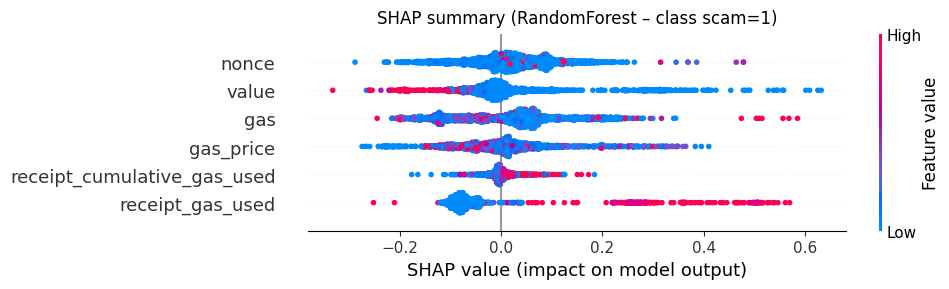

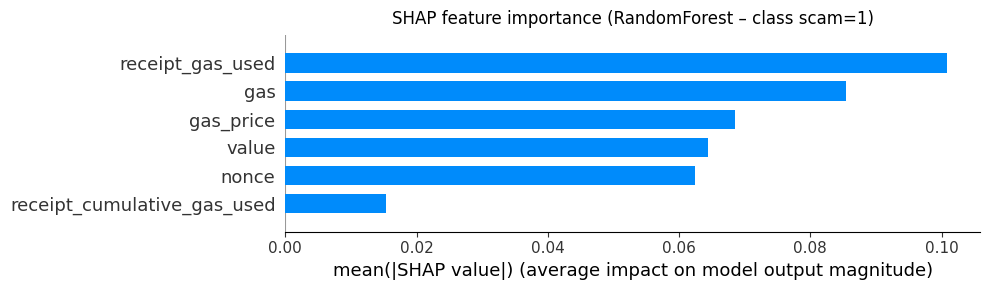


================ SHAP cho XGBoost ================


 99%|===================| 1974/2000 [00:36<00:00]        

  sv_pos.shape = (2000, 6) | ndim = 2


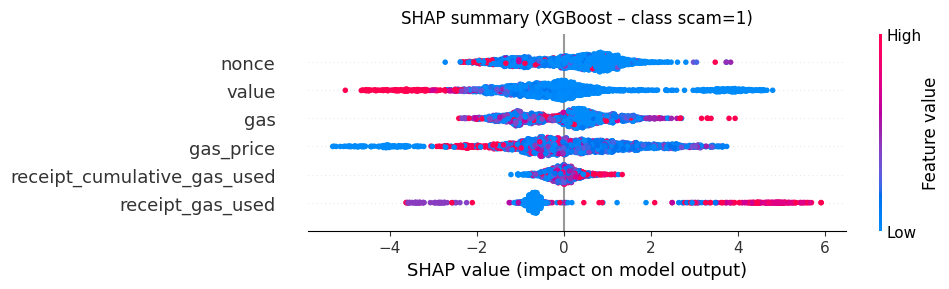

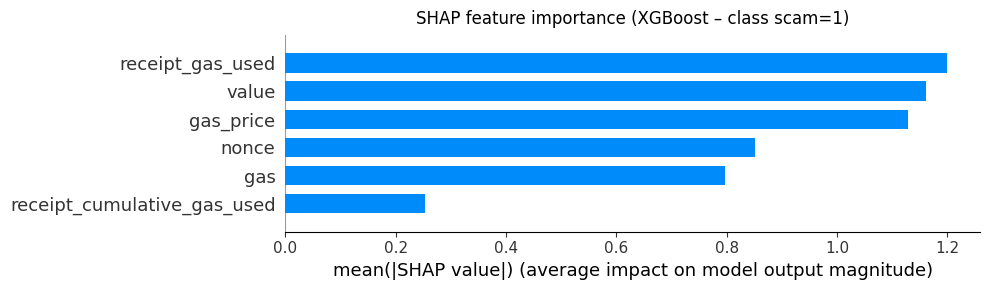


================ SHAP cho LightGBM ================


 99%|===================| 1976/2000 [00:42<00:00]        

  sv_pos.shape = (2000, 6) | ndim = 2


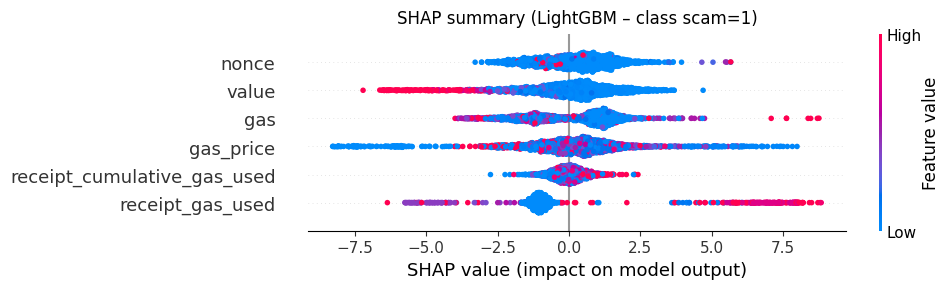

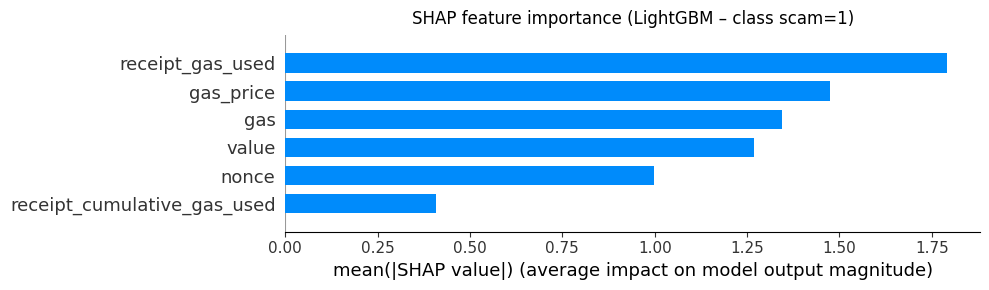


===== Local SHAP cho 1 transaction – XGBoost =====
True label      : 0
Model predicted : 0


100%|===================| 1995/2000 [00:36<00:00]        

In [16]:
# ==========================================
# SHAP cho 3 model: RF, XGB, LGBM (CHỈ SHAP VALUE)
# ==========================================
import shap
import numpy as np
import matplotlib.pyplot as plt

shap.initjs()

models = {
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": best_lgbm
}

# background + sample để giải thích
n_background = min(2000, X_train_scaled.shape[0])
n_explain    = min(2000, X_test_scaled.shape[0])

X_background = X_train_scaled[:n_background]
X_explain    = X_test_scaled[:n_explain]

print(f"Background SHAP size: {X_background.shape}")
print(f"Explain SHAP size   : {X_explain.shape}")

for name, model in models.items():
    print(f"\n================ SHAP cho {name} ================")

    expl = shap.TreeExplainer(
        model,
        data=X_background,
        feature_perturbation="interventional"
    )

    # ---- CHỈ DÙNG shap_values, KHÔNG interaction ----
    sv = expl.shap_values(
        X_explain,
        check_additivity=False
    )

    # ----- Chuẩn hoá về SHAP cho class=1, shape (n_samples, n_features) -----
    # Trường hợp 1: shap trả về list [class0, class1]
    if isinstance(sv, list):
        if hasattr(model, "classes_"):
            cls_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            cls_idx = 1
        sv_pos = sv[cls_idx]

        if isinstance(expl.expected_value, (list, np.ndarray)):
            expected_pos = expl.expected_value[cls_idx]
        else:
            expected_pos = expl.expected_value

    # Trường hợp 2: shap trả về array 3D (n_samples, n_features, n_classes)
    elif isinstance(sv, np.ndarray) and sv.ndim == 3:
        if hasattr(model, "classes_"):
            cls_idx = int(np.where(model.classes_ == 1)[0][0])
        else:
            # fallback: nếu không có classes_, chọn lớp cuối cùng
            cls_idx = sv.shape[2] - 1

        # bóc lớp cuối cùng -> (n_samples, n_features)
        sv_pos = sv[:, :, cls_idx]

        if isinstance(expl.expected_value, (list, np.ndarray)):
            ev = expl.expected_value
            ev = np.array(ev)
            if ev.ndim == 1 and ev.shape[0] >= cls_idx + 1:
                expected_pos = ev[cls_idx]
            else:
                expected_pos = ev
        else:
            expected_pos = expl.expected_value

    # Trường hợp 3: shap trả về array 2D sẵn
    else:
        sv_pos = sv
        expected_pos = expl.expected_value

    print("  sv_pos.shape =", sv_pos.shape, "| ndim =", sv_pos.ndim)
    assert sv_pos.ndim == 2, "sv_pos vẫn không phải 2D, SHAP trả format lạ."

    # ===== 1) summary plot (dot) =====
    # ==== 1) Summary plot dạng dot ====
    shap.summary_plot(
        sv_pos,
        X_explain,
        feature_names=feature_cols,
        sort=False,      # hoặc False nếu muốn giữ nguyên thứ tự feature
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(10, 3)
    plt.title(f"SHAP summary ({name} – class scam=1)", pad=8)
    plt.tight_layout()
    plt.show()

    # ==== 2) Feature importance dạng bar ====
    shap.summary_plot(
        sv_pos,
        X_explain,
        feature_names=feature_cols,
        plot_type="bar",
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(10, 3)
    plt.title(f"SHAP feature importance ({name} – class scam=1)", pad=8)
    plt.subplots_adjust(top=0.85, left=0.25)
    plt.tight_layout()
    plt.show()

# (tuỳ chọn) Local explanation cho 1 transaction với XGBoost
idx = 0
main_model_name = "XGBoost"
model = models[main_model_name]

print(f"\n===== Local SHAP cho 1 transaction – {main_model_name} =====")
print("True label      :", y_test[idx])
print("Model predicted :", model.predict(X_test_scaled[idx:idx+1])[0])

expl_local = shap.TreeExplainer(
    model,
    data=X_background,
    feature_perturbation="interventional"
)
sv_local = expl_local.shap_values(
    X_explain,
    check_additivity=False
)

# Chuẩn hoá như trên, nhưng chỉ cho XGB
if isinstance(sv_local, list):
    if hasattr(model, "classes_"):
        cls_idx = int(np.where(model.classes_ == 1)[0][0])
    else:
        cls_idx = 1
    sv_local_pos = sv_local[cls_idx]
    ev_local = expl_local.expected_value
    if isinstance(ev_local, (list, np.ndarray)):
        ev_local_pos = np.array(ev_local)[cls_idx]
    else:
        ev_local_pos = ev_local
elif isinstance(sv_local, np.ndarray) and sv_local.ndim == 3:
    if hasattr(model, "classes_"):
        cls_idx = int(np.where(model.classes_ == 1)[0][0])
    else:
        cls_idx = sv_local.shape[2] - 1
    sv_local_pos = sv_local[:, :, cls_idx]
    ev = np.array(expl_local.expected_value)
    ev_local_pos = ev[cls_idx] if ev.ndim == 1 else ev
else:
    sv_local_pos = sv_local
    ev_local_pos = expl_local.expected_value

shap.force_plot(
    ev_local_pos,
    sv_local_pos[idx, :],
    X_explain[idx, :],
    feature_names=feature_cols
)
